In [1]:
# Load required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import itertools
import verde as vd

In [2]:
grid = xr.open_dataset("../../data/evel_2017.grd")
grid["north_velocity"] = xr.open_dataarray('../../data/nvel_2017.grd')
grid["up_velocity"] = xr.open_dataarray('../../data/uvel_2017.grd')
grid = grid.rename(dict(z="east_velocity", x="longitude", y="latitude"))
grid

<xarray.Dataset>
Dimensions:         (latitude: 2700, longitude: 3333)
Coordinates:
  * longitude       (longitude) float64 -127.0 -127.0 -127.0 ... -110.3 -110.3
  * latitude        (latitude) float64 28.0 28.01 28.01 ... 41.49 41.49 41.5
Data variables:
    east_velocity   (latitude, longitude) float32 ...
    north_velocity  (latitude, longitude) float32 ...
    up_velocity     (latitude, longitude) float32 ...
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        evel_2017.grd
    history:      grdsample vjunk.grd -Gevel_2017.grd -T
    GMT_version:  4.5.12 [64-bit]
    node_offset:  1

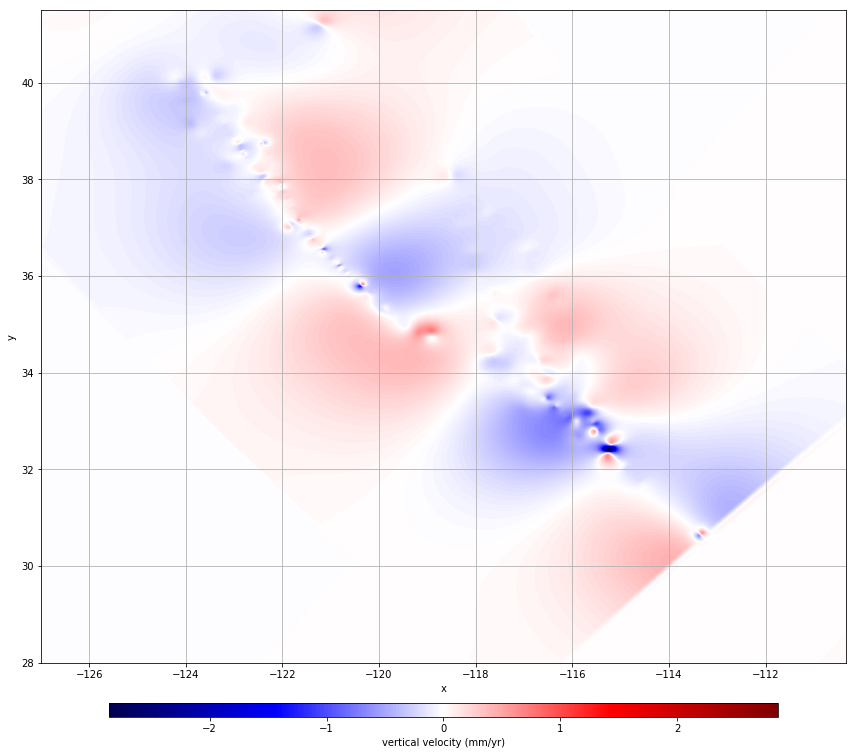

In [3]:
plt.figure(figsize=(15, 15))
ax = plt.subplot(111)
cbargs = dict(orientation="horizontal", aspect=50, pad=0.05, label="vertical velocity (mm/yr)",
              shrink=0.8)
maxabs = vd.maxabs(grid.up_velocity)
grid.up_velocity.plot.pcolormesh(ax=ax, vmin=-maxabs, vmax=maxabs, cmap="seismic",
                                 cbar_kwargs=cbargs)
indexer = slice(None, None, 100)
# Downsample the arrows so we can actually see something
down = grid.isel(longitude=indexer, latitude=indexer)
#ax.quiver(down.longitude, down.latitude, down.east_velocity, down.north_velocity, scale=500, width=0.001)
ax.set_aspect("equal")
ax.grid()

In [16]:
region = (-123, -115, 33, 38)
spacing = 0.02
lon, lat = vd.grid_coordinates(region, spacing=spacing)
sub = grid.interp(dict(latitude=lat[:, 0], longitude=lon[0, :]))
sub

<xarray.Dataset>
Dimensions:         (latitude: 251, longitude: 401)
Coordinates:
  * latitude        (latitude) float64 33.0 33.02 33.04 ... 37.96 37.98 38.0
  * longitude       (longitude) float64 -123.0 -123.0 -123.0 ... -115.0 -115.0
Data variables:
    east_velocity   (latitude, longitude) float64 -12.46 -12.47 ... 10.57 10.57
    north_velocity  (latitude, longitude) float64 14.41 14.4 ... -13.93 -13.94
    up_velocity     (latitude, longitude) float64 0.06077 0.0611 ... -0.02325
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        evel_2017.grd
    history:      grdsample vjunk.grd -Gevel_2017.grd -T
    GMT_version:  4.5.12 [64-bit]
    node_offset:  1

In [17]:
region_str = "/".join(str(i) for i in region)
!gmt grdlandmask -G../../data/synthetic-landmask.nc -I$spacing -R$region_str

gmt: /home/leo/miniconda3/lib/libcurl.so.4: no version information available (required by /home/leo/pkg/lib64/libgmt.so.6)


In [18]:
with xr.open_dataset("../../data/synthetic-landmask.nc") as mask_ds:
    mask = mask_ds.rename(dict(lat="latitude", lon="longitude")).load()
mask

<xarray.Dataset>
Dimensions:    (latitude: 251, longitude: 401)
Coordinates:
  * longitude  (longitude) float64 -123.0 -123.0 -123.0 ... -115.0 -115.0 -115.0
  * latitude   (latitude) float64 33.0 33.02 33.04 33.06 ... 37.96 37.98 38.0
Data variables:
    z          (latitude, longitude) float32 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
Attributes:
    Conventions:  CF-1.7
    history:      grdlandmask -G../../data/synthetic-landmask.nc -I0.02 -R-12...
    description:  Derived from the low resolution shorelines
    GMT_version:  6.0.0_9c729d4 [64-bit]

In [19]:
sub = sub.where(mask.z.values)
sub

<xarray.Dataset>
Dimensions:         (latitude: 251, longitude: 401)
Coordinates:
  * latitude        (latitude) float64 33.0 33.02 33.04 ... 37.96 37.98 38.0
  * longitude       (longitude) float64 -123.0 -123.0 -123.0 ... -115.0 -115.0
Data variables:
    east_velocity   (latitude, longitude) float64 nan nan nan ... 10.57 10.57
    north_velocity  (latitude, longitude) float64 nan nan nan ... -13.93 -13.94
    up_velocity     (latitude, longitude) float64 nan nan ... -0.02379 -0.02325
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        evel_2017.grd
    history:      grdsample vjunk.grd -Gevel_2017.grd -T
    GMT_version:  4.5.12 [64-bit]
    node_offset:  1

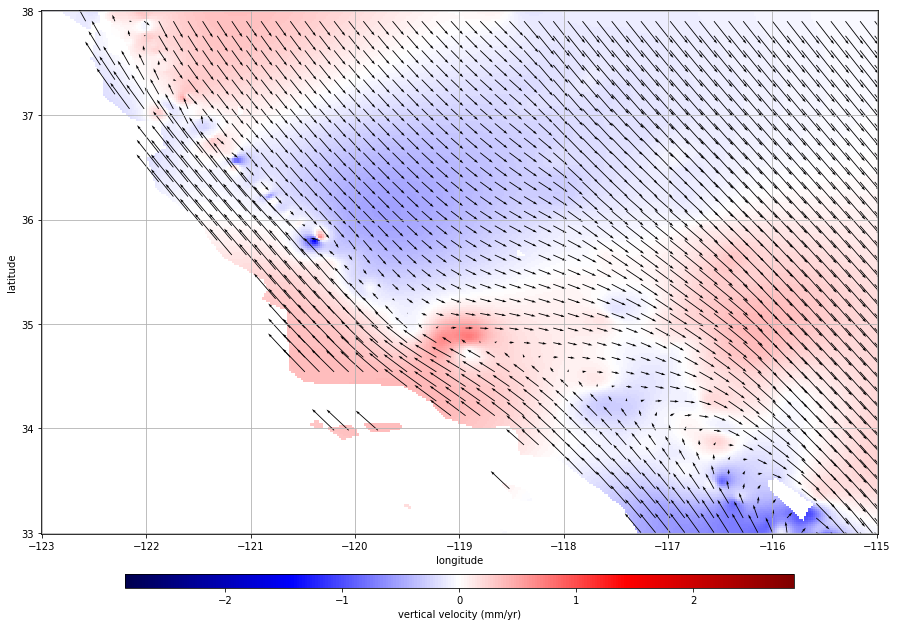

In [20]:
plt.figure(figsize=(15, 15))
ax = plt.subplot(111)
cbargs = dict(orientation="horizontal", aspect=50, pad=0.05, label="vertical velocity (mm/yr)",
              shrink=0.8)
maxabs = vd.maxabs(grid.up_velocity)
sub.up_velocity.plot.pcolormesh(ax=ax, vmin=-maxabs, vmax=maxabs, cmap="seismic",
                                 cbar_kwargs=cbargs)
indexer = slice(None, None, 7)
# Downsample the arrows so we can actually see something
down = sub.isel(longitude=indexer, latitude=indexer)
ax.quiver(down.longitude, down.latitude, down.east_velocity, down.north_velocity, scale=500, width=0.001)
ax.set_aspect("equal")
ax.grid()

In [21]:
sub.to_netcdf("../../data/synthetic-san-andreas-2017.nc")